In [1]:
%matplotlib notebook
import numpy as np
import pickle as pk
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# with open('/workspaces/pyskl/work_dirs/stgcn_ntu60_coco_1/last_pred.pkl', 'rb') as f:
#     pred = pk.load(f)
# # print(len(context))

ensemble_num = 4
ensemble_idx = [1, 2, 4, 5]
pred_ensemble = []
for idx in ensemble_idx:
    with open(f'/workspaces/pyskl/work_dirs/stgcn_custom_5_custom2_1conf_{idx}/best_pred.pkl', 'rb') as f:
        pred = pk.load(f)
    pred_ensemble.append(pred)

In [3]:
with open('/workspaces/pyskl/data_generate/datasets_action_5_10fps_120test/custom_hrnet_11kp_1conf.pkl', 'rb') as f:
    gt = pk.load(f)
print(gt.keys())
print(gt['split'].keys())

true_num_ = 0
true_num = 0
true_uncert = []
false_uncert = []
for idx, item in enumerate(gt['split']['test']):
    
    # 根据gt中sub_val的划分，获取真值
    for i in gt['annotations']:
#         print(i['frame_dir'])
        if item == i['frame_dir']:
            gt_label = i['label']
            break
            
    all = np.concatenate(
        ([pred_ensemble[i][idx][np.newaxis,...] for i in range(len(pred_ensemble))]),
        axis = 0
    )
        
    # disagreement / uncertainty
    uncertainty = 0
    pred_mean = np.mean(all, axis=0)
    for each in all:
        uncertainty += np.sum(each * (np.log(each+1e-20) - np.log(pred_mean+1e-20)))
    uncertainty = uncertainty / len(ensemble_idx)
        
    # 单个模型的预测结果
    pred = all[1]
    pred_label = np.argmax(pred)
    if gt_label == pred_label:
        true_num += 1
    
    # 集成模型的预测结果
    pred_ = np.mean(all, axis=0)
    pred_label_ = np.argmax(pred_)
    if gt_label == pred_label_:
        true_num_ += 1
        true_uncert.append(uncertainty)
    else:
        false_uncert.append(uncertainty)
        
#     if gt_label != pred_label and gt_label == pred_label_:
#         print(item)
    
    if gt_label != pred_label:
        print(item)


test_num = len(gt['split']['test'])
print(true_num/test_num)
print(true_num_/test_num)

dict_keys(['split', 'annotations'])
dict_keys(['train', 'test'])
right_person1_0078_test
right_person1_0079_test
right_person1_0080_test
right_person1_0083_test
0.9666666666666667
0.9583333333333334


<IPython.core.display.Javascript object>


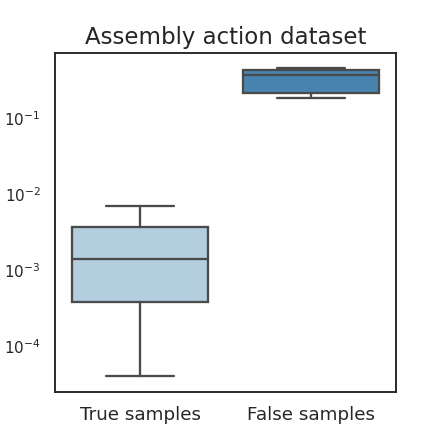

In [7]:
false_uncert = list(itertools.islice(itertools.cycle(false_uncert), len(true_uncert)))

df = pd.DataFrame({'True samples': true_uncert, 'False samples': false_uncert})

plt.figure(figsize=(4, 4))  # Set the figure size
sns.set(style="white", font_scale=0.9)  # Set the style
plt.yscale('log')
# plt.ylabel('Uncertainty', fontsize=12)
plt.xticks(fontsize=12)
plt.title("Assembly action dataset", fontsize=15)

sns.boxplot(data=df, dodge=False, showfliers=False, palette="Blues")
plt.show()
plt.savefig(r'/workspaces/pyskl/workspace/notebooks/compares_custom.svg', bbox_inches = 'tight')

In [5]:
with open('/workspaces/pyskl/demo/results/long_view2_uncertainty.pkl', 'rb') as f:
    context = pk.load(f)
print(context.keys())

dict_keys(['predictions', 'uncertainties'])


<IPython.core.display.Javascript object>


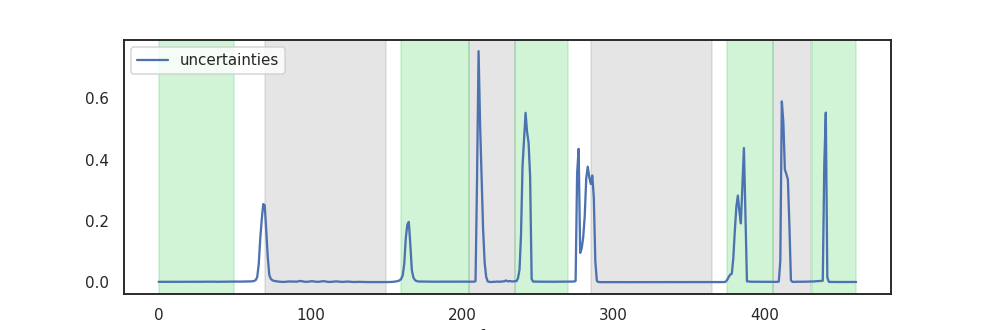

In [6]:
iters = [it for it in range(len(context['predictions']))]

# predictions = context['predictions']
uncertainties = np.array(context['uncertainties'])
# print(predictions)

plt.figure(figsize=(9, 3))  # Set the figure size
sns.set(style="white", font_scale=0.9)  # Set the style
# {deep, muted, pastel, dark, bright, colorblind}
sns.set_color_codes(palette='bright')
plt.xlabel('frames')

# sns.lineplot(x=iters, y=predictions, linestyle="-", color='r', label="predictions")
sns.lineplot(x=iters, y=uncertainties, linestyle="-", color='b', label="uncertainties")


# stand
plt.gca().axvspan(0, 50, alpha=0.2, color='g')
# polish
plt.gca().axvspan(70, 150, alpha=0.2, color='grey')
# stand
plt.gca().axvspan(160, 205, alpha=0.2, color='g')
# right
plt.gca().axvspan(205, 235, alpha=0.2, color='grey')
# stand
plt.gca().axvspan(235, 270, alpha=0.2, color='g')
# assembly
plt.gca().axvspan(285, 365, alpha=0.2, color='grey')
# stand
plt.gca().axvspan(375, 405, alpha=0.2, color='g')
# left
plt.gca().axvspan(405, 430, alpha=0.2, color='grey')
# stand
plt.gca().axvspan(431, 460, alpha=0.2, color='g')

plt.show()
plt.savefig('/workspaces/pyskl/workspace/notebooks/long_horizon_uncertainty.svg', bbox_inches = 'tight')